# VLE of glassy polymers

This is an example for a VLE calculation featuring a polymer and a solvent. PC-SAFT calculation for a water sorption isotherm of the polymer PVP were performed (the dotted line in Figure 2 of https://doi.org/10.3390/membranes12040434). 

In [6]:
import numpy as np
from diffusionpy import vpure,lngi,SAFTSAC
import matplotlib.pyplot as plt
from scipy.optimize import root,root_scalar

def convert(xi,Mi):
    return xi*Mi[:,None]/np.sum(xi*Mi[:,None],axis=0)

The the first part of the code is basically the same as presented in VLE_Water_Sorption_Polymer_part1.ipynb

In [7]:
mi=np.asarray([1.20469,1045.99,14.2829768])
sigi=np.asarray([2.797059952,2.71,3.535])
ui=np.asarray([353.95,205.599,262.791])
epsAiBi=np.asarray([2425.67,0.,886.44])
kapi=np.asarray([0.04509,0.02,0.02])
N=np.asarray([1.,231.,3.])
Mi=np.asarray([18.015,25700.,357.79])
kij=np.asarray([
    [0.,-0.128,-0.025],
    [-0.128,0.,-0.0621],
    [-0.025,-0.0621,0.]])
kijA=np.asarray([[0.]])

In [14]:
T=298.15
p=1E5
vpures=vpure(p,T,mi,sigi,ui,epsAiBi,kapi,N)
npoint=100
w1=np.linspace(0,1,npoint)
w2=1-w1
wi_immobiles=np.asarray([0.5,0.5])
wi=np.vstack((w1,w2*wi_immobiles[0],w2*wi_immobiles[1]))
xi=convert(wi,1/Mi)
lngammai=np.asarray([lngi(T,np.ascontiguousarray(wi[:,i]),mi,sigi,ui,epsAiBi,kapi,N,vpures,Mi,kij,kijA).flatten() for i,val in enumerate(wi[0,:])])
mobiles=np.asarray([True,False,False])
immobiles=~mobiles

ksw = 0.4279 #/ 0.03166**2
v0p = Mi[1]/1506.704837/1000.
v0a = vpures[2]
v0ASD=(1/1506.704837/1000*wi_immobiles[1]+v0a/Mi[2]*wi_immobiles[1])*(Mi[1]*wi_immobiles[0]+Mi[2]*wi_immobiles[1])


In [15]:
def NETVLE(RH,ww):
    wi=np.asarray([ww,(1-ww)*wi_immobiles[0],(1-ww)*wi_immobiles[1]])
    xi=convert(wi[:,None],1./Mi)[:,0]
    xw=xi[mobiles]
    vmol=v0ASD/(1-ksw*RH**2)*(1-np.sum(xw))
    # vpures[1]=xw/(1-xw)*(1-ksw*RH**2)/(ksw*RH**2)*vpures[0]
    vpures[immobiles]=(vmol-np.sum(xw*vpures[mobiles]))/(1-np.sum(xw))*wi_immobiles
    lngid,lngres,_,lngw=SAFTSAC(T,wi,mi,sigi,ui,epsAiBi,kapi,N,vpures,Mi,kij,kijA)
    return lngid[mobiles]+lngres[mobiles]+lngw[mobiles]+np.log(ww)

RHvec=[]
wnet=np.linspace(0.01,0.4,npoint)
for i,val in enumerate(wnet):
    res=lambda RH : NETVLE(RH,val)-np.log(RH)
    RHvec.append(root(res,val,method='broyden1')["x"])
RHvec=np.asarray(RHvec)

LinAlgError: Array must not contain infs or NaNs.

ValueError: x and y must have same first dimension, but have shapes (0,) and (100,)

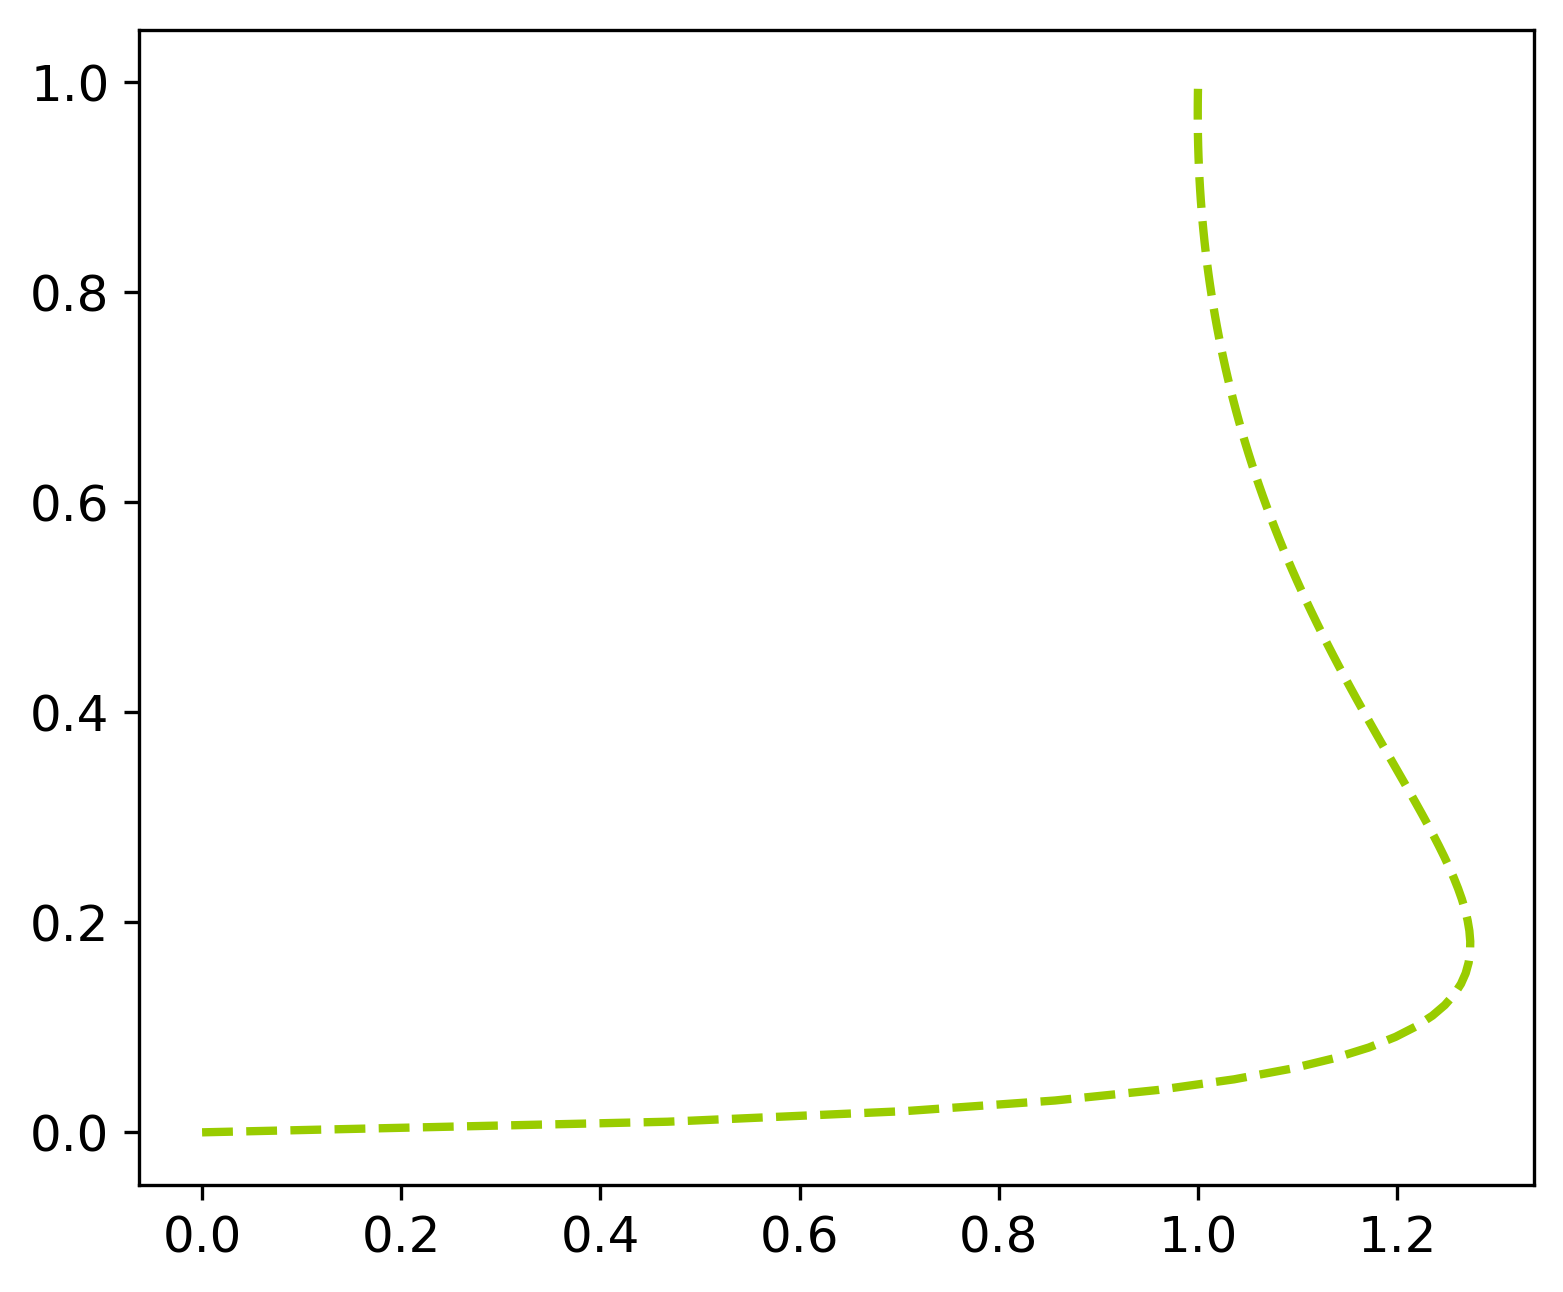

In [ ]:


font = {'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

colorVLE = "#99CC00"

fig, ax = plt.subplots(figsize = (6, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

RHexp = [0.9868,0.9858,0.9787,0.9749,0.9724,0.9685,0.9576,0.9565,0.9563,0.9217,0.89,0.8519,0.7998,0.7529]
wexp = [0.704,0.6808,0.6142,0.593,0.5808,0.5638,0.5162,0.5096,0.506,0.4175,0.3672,0.3193,0.275,0.246]

RHexp2 = [0.0924,0.2939,0.4449,0.599,0.7344,0.8781]
wexp2 = [0.0274269,0.0821512,0.1275743,0.1764984,0.237775,0.3401576]


w1vecnet=np.asarray([0,0.01010101,0.03030303,0.05050505050505051,0.07070707,0.08080808,0.1010101,0.15151515,0.2020202,0.2525252,0.29292929,0.32323232,0.35353535,0.36363636,0.37373737 ])

RHvecnet=np.asarray([0,0.08918283177229723,0.13443607581986078,0.1760292767458166,0.23249529616442166,0.2672469998598751,0.339728603928366,0.5152843958145663,0.6584131146365886,0.7752373315670975,0.8549372175803867,0.9084896086230553,0.957630227423256,0.9732295774807403,0.9882587661995547])


ax.plot(np.exp(lngammai[:,0]+np.log(w1)),w1, "--",color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(RHvec,wnet, "-.",color = colorVLE , 
        linewidth = 2.0, label = "NET-GP")
# ax.plot(RHvec[RHvec<RHvecnet],w1vec[RHvec<RHvecnet], "-",color = colorVLE , 
#         linewidth = 2.0, label = "PC-SAFT+NET-GP")
# ax.plot(RHvecnet[RHvec>RHvecnet],w1vecnet[RHvec>RHvecnet], "-",color = colorVLE , 
#         linewidth = 2.0)


ax.scatter(RHexp, wexp, s = 100, c = colorVLE, marker="^", 
            linewidth=1.0, edgecolor='k', label = "rubbery")
ax.scatter(RHexp2, wexp2, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "glassy")



ax.legend(fontsize="small")
ax.set_ylabel('$w_w$ / -')
ax.set_xlabel('$RH$ / -')
ax.axis([0, 1., 0, 0.8])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))
plt.show()